# Planet Labs Image Selection Demo

In [4]:
data = Snapshot("/Users/chelm/.timbr/data/San Diego Image Metadata (Planet Labs - RapidEye).h5")

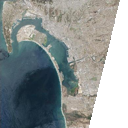

2014-04-30T19:37:49.000000Z 20140430_193749_1154114_RapidEye-3


In [5]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import Image, display
import base64 as b64

@interact(i=widgets.IntSlider(min=0,max=len(data)-1,step=1,value=0))
def f(i):
    img = data[i][-1]
    display(Image(data=b64.b64decode(img["thumbnail"]["__data__"]), width=250, height=250))
    print img['properties']['acquired'], img['id']

In [6]:
scene_ids = [
    "20160324_190655_1154114_RapidEye-3",
    "20150326_192901_1154114_RapidEye-5",
    "20140403_193228_1154114_RapidEye-5",
    "20131125_192646_1154114_RapidEye-5"
]

## Downloading Geotiffs

./san_diego_4_11_16/visual/20160324_190655_1154114_RapidEye-3_visual.tif


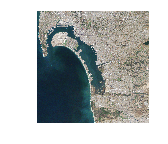

./san_diego_4_11_16/visual/20150326_192901_1154114_RapidEye-5_visual.tif


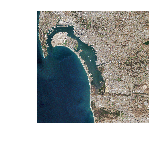

./san_diego_4_11_16/visual/20140403_193228_1154114_RapidEye-5_visual.tif


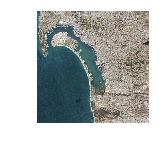

./san_diego_4_11_16/visual/20131125_192646_1154114_RapidEye-5_visual.tif


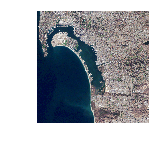

In [130]:
from planet import api
import sys, os
import urllib2, httplib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class NoRedirection(urllib2.HTTPErrorProcessor):
    def http_response(self, request, response):
        return response
    https_response = http_response

opener = urllib2.build_opener(NoRedirection)

def get_image(scene, scene_type='visual', data_dir="./planet_images"):
    img_dir = os.path.join(data_dir, scene_type)
    if not os.path.exists( img_dir ):
        os.makedirs(img_dir)
        
    url = scene['properties']['data']['products'][scene_type]['full']
    
    filename = os.path.join(img_dir, '%s_%s.tif' % (scene['id'], scene_type)) 
    req = urllib2.Request(url, headers={"Authorization": "api-key %s" % api_key})
    response = opener.open(req)
    
    if 'Location' in response.headers:
        redirect_url = response.headers['Location']
        req = urllib2.Request(redirect_url)
        response = opener.open(req)
    
    CHUNK = 16 * 1024
    total = 0
    with open(filename, 'wb') as f:
        while True:
            chunk = response.read(CHUNK)
            if not chunk:
                sys.stdout.flush()
                sys.stdout.write('why?')
                break
                
            total += CHUNK
            sys.stdout.flush()
            sys.stdout.write('\r>> Downloading %s %d' % (filename, total))
            f.write(chunk)
            
            
scenes     = {s['id']: s for i, s in data }
api_key    = '65a347d4358348189a800a5eac3bcde7'
data_dir   = './san_diego_4_11_16'
scene_type = 'visual'                    
scene_meta = [ scenes[i] for i in scene_ids ]
    
for scene in scene_meta:
    filename = os.path.join(data_dir, scene_type, scene['id'] + '_' + scene_type + '.tif')
    if not os.path.exists(filename):
        get_image(scene, scene_type=scene_type, data_dir=data_dir)
        
    print filename
    fig, ax = plt.subplots(1, figsize=(2,2), facecolor='white')
    ax.axis('off')
    imgplot = plt.imshow(mpimg.imread(filename))
    plt.show() 
     

## Clipping Imagery to the San Diego Naval Base

To compare each image we first clip each one to the same area. We use a BBOX to select array indices that extract an area of interest from each image and stores them as a Numpy nd-array. 

In [ ]:
import os
import rasterio
import matplotlib.image as mpimg

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

import matplotlib.cm as cm 


def xy_from_coords(x_coord, y_coord, ul, lr, width, height):
    x0, x1 = ul[0], lr[0]
    y0, y1 = ul[1], lr[1]
    x_diff = x1 - x0
    y_diff = y0 - y1
    xpx =  ((x1 - x_coord) / x_diff) * width
    if y0 - y_coord == 0.0:
        ypx = height
    elif y_diff != 0:
        ypx = (y0 - y_coord) / y_diff * height
    else:
        ypx = 0
    return int(abs(xpx-width)), int(ypx)


def clip_image(bbox, filepath):
    with rasterio.drivers():
        with rasterio.open(filepath) as src:
            bounds = src.bounds
            ul, lr = [bounds.left, bounds.top], [bounds.right, bounds.bottom]
            r, g, b, a = src.read()
            np_img = np.dstack((r, g, b, a))
            ul_px = xy_from_coords(bbox[0], bbox[3], ul, lr, src.width, src.height)
            lr_px = xy_from_coords(bbox[2], bbox[1], ul, lr, src.width, src.height)
            return np_img[ul_px[0]:lr_px[0], ul_px[1]:lr_px[1], :]
        
def render_array(arr1, arr2=None, width=5, height=5):
    if arr2 is None:
        fig, ax = plt.subplots(1, figsize=(width,height), facecolor='white')
        ax.axis('off')
        plt.imshow(arr1)
        plt.show()
    else: 
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
        fig.set_size_inches(width, height)
        ax1.imshow(arr2)
        ax1.axis('off')
        ax2.imshow(arr1)
        ax2.axis('off')
            

bbox = [483275.7009112152, 3610083.6489744713, 486785.39847831125, 3613762.760762966]

data_dir = './san_diego_4_11_16/visual/'
files = os.listdir(data_dir)
clipped = [clip_image(bbox, os.path.join( data_dir, f )) for f in files]
render_array(clipped[0])

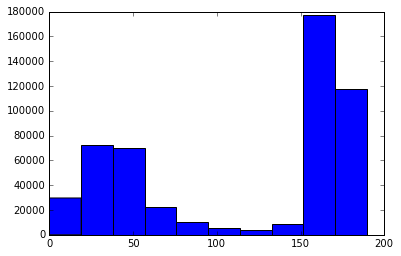

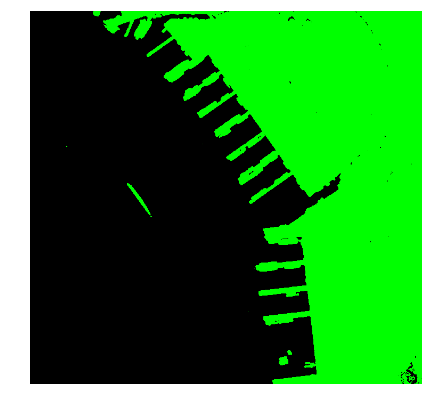

In [297]:
def average(arr):
    return np.average(arr, axis=2)

def fast_mask(arr, threshold=135, x=100, y=300):
    water_px = arr[x,y]
    dist_arr = np.abs(arr - water_px)
    mask = np.ndarray(dist_arr.shape + (3,)).astype(np.uint8)
    below = dist_arr < threshold
    mask[below] = [0,255,0]
    return mask, dist_arr
    
avg = average(np.copy(clipped[3][:,:,0:2]))
mask, dist = fast_mask(avg, threshold=135, x=100, y=300)
plt.hist(dist.flatten())
#mask = fast_mask(np.copy(clipped[3]), threshold=400, x=100, y=300)    
render_array(mask, width=7, height=7)



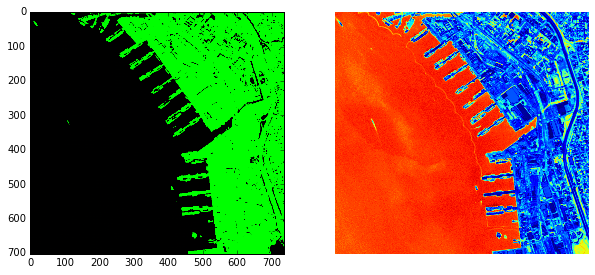

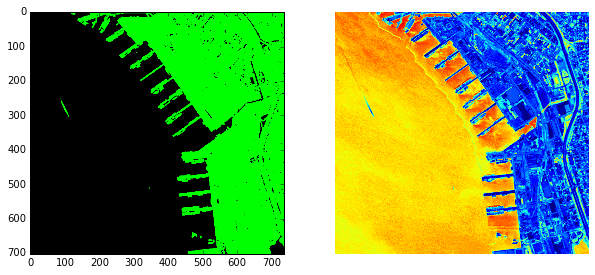

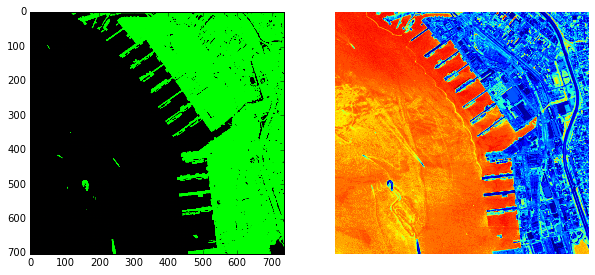

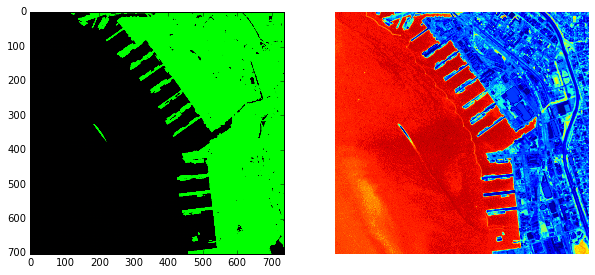

In [314]:
threshold = 450

#np_img = np.dstack()
masks = []
for image_arr in clipped:
    avg = np.average(np.copy(image_arr[:,:,0:2]), axis=2)
    mask, dist = fast_mask(avg)
    masks.append(mask)
    render_array(dist, mask, width=10, height=10)
    
